# Import

In [1]:
import numpy as np
from scipy.stats import norm
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import statistics
from scipy import signal
from scipy.optimize import curve_fit
import scipy.fftpack
from scipy import interpolate
from cycler import cycler
from inspect import signature

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
%matplotlib notebook

# Reading files

In [3]:
def read_data_file(common_folder, folder_in, Rl, N, file_type, spec_type, spec_component, run_files) :
    nb_of_runs = len(run_files)
    for run_index in list(range(nb_of_runs)) :
        folder = common_folder + "rl" + str(Rl) + "_N" + str(N) + "/" + folder_in + "run" + "%01d" % (run_index+1) + "/"
        if (run_files[run_index] < 1000) :
            file = folder + file_type + "_" + spec_type + "_C" + spec_component + "_wi=" + "%03d" % run_files[run_index] + ".table"
        else : 
            file = folder + file_type + "_" + spec_type + "_C" + spec_component + "_wi=" + "%06d" % run_files[run_index] + ".table"
        file_data = []
        averaging_weight = (run_files[run_index]+1)/(sum(run_files)+nb_of_runs)
        for line in open(file) :
            temp_array_line = []
            if line[0] == '#' :          #skip commented lines
                continue
            else :
                temp_array_line=list(map(float, line.split( )))
                temp_array_line = [t * averaging_weight for t in temp_array_line]
                file_data.append(temp_array_line)  
        if (run_index == 0) : 
            accumulated_data = file_data.copy()
        else : 
            accumulated_data = list(map(lambda l1, l2: [sum(x) for x in zip(l1, l2)], accumulated_data, file_data))
    k = np.array(accumulated_data[0])
    nb_of_modes = np.array(accumulated_data[1])
    average_data = np.ndarray(shape=(len(accumulated_data)-2, k.shape[0]+1), dtype=float)
    for i in list(range(average_data.shape[0])) : 
        average_data[i, :] = np.array(accumulated_data[i+2])
    t = average_data[:,0]
    numpy_file_table = np.array(average_data[:,1:])
    return [k, nb_of_modes, t, numpy_file_table]

In [4]:
common_folder = "/home/gorbunov8a/data/filtered_advection/"
folder_in = "test_small/"
Rl = 60; N=128
run_files=[67]
run_files=[1]
spec_type = "lin"
spec_component = "avg"

In [5]:
[k, nb_of_modes, t, total_t] = read_data_file(common_folder, folder_in, Rl, N, "total_transfer_corr", spec_type, spec_component, run_files)
[k, nb_of_modes, t_corr, correlation] = read_data_file(common_folder, folder_in, Rl, N, "two_point_corr", spec_type, "avg", run_files)

In [6]:
# read the spectrum
file_type = "transfer_spec_lin_ite="
nb = 56000
nb=205
file = '/home/gorbunov8a/data/filtered_advection/rl90_N256/test/run1/' + file_type + "%06d" % nb + ".table"
file = '/home/gorbunov8a/data/filtered_advection/rl60_N128/test_small/run1/' + file_type + "%06d" % nb + ".table"
file_data = []
for line in open(file) :
    temp_array_line = []
    if line[0] == '#' :          #skip commented lines
        continue
    else :
        temp_array_line=list(map(float, line.split( )))
        file_data.append(temp_array_line)  
spec_table = np.array(file_data)
#k = spec_table[:,0]
#nb_of_modes = spec_table[:,1]
transfer_spec = spec_table[:,2]
del file_data

In [7]:
### RESHAPE
# tL1 = transfer_f1.shape[0]
# tL2 = transfer_f2.shape[0]
# transfer_f2 = transfer_f2[(tL2-tL1)//2:(tL2+tL1)//2:,::]

In [8]:
# # total_t - all energy transgers to the shell k
# # t_ss - energy transfers between small scales
# # t_sss - only transfers with all three small modes
# # t_sls - energy transfer between small scales with a large scale mediator mode
# # t_sl - non-local transfer to small scales from large scales
# t_sls = t_ss - t_sss    
# t_sl = total_t - t_ss
# #t_sll = t_sl - t_ssl

# Define parameters

In [9]:
# PARAMETERS
#nu = 0.01
nu = 0.0001
pi = np.pi
if (Rl == 60) :
    lmbda = 0.378
    eta = 0.0254807  
    L = 2.23  
    #dissipation_rate = 2.37307
    dissipation_rate = 0.2244E-5
    #e_kine = 3.52497
    e_kine = 0.39
    cut_off_k = 12.0
if (Rl == 90) :
    lmbda = 0.2352
    eta = 0.126e-1
    dissipation_rate = 0.3919e-4
    L = 2.2
    cut_off_k = 25.0
if (Rl == 160):
    lmbda = 0.155
    eta = 0.006436  
    L = 2.2
    dissipation_rate = 0.6E-3  
    cut_off_k = 40.0

t0=dissipation_rate**(-1/3)*L**(2/3) #large scale eddy-turnover time
print(t0)
spatial_scales = np.array([L, lmbda, eta])
normalization_status = True


ikf = int(np.searchsorted(k, cut_off_k))
ik2f = int(np.searchsorted(k, 2*cut_off_k))
print(ik2f)

130.3753911814338
23


# Normalization

In [10]:
t_length=t.shape[0]
wavenumbers_length=k.shape[0]
if normalization_status :
#     k_norm_coef = L
#     t_norm_coef = 1.0/t0
#     t=t*t_norm_coef
#     k=k*k_norm_coef
#     spatial_scales = 1.0/k_norm_coef * spatial_scales
    
    normalization = (correlation[0,:])**(-1)
else : 
    normalization = np.ones(wavenumbers_length)

wn_scales = 2.0*np.pi/spatial_scales
kL = 2.0*pi/L; klmbda = 2.0*pi/lmbda; keta = 2.0*pi/eta

spheric_coeff = 4.0*np.pi*(k**2)/nb_of_modes

In [11]:
#find wavenumber corresponding to the dealiasing cut-off
shift_init=20
ik_max = shift_init + (np.argwhere(spheric_coeff[shift_init::]>1.025)[0])[0]
print(ik_max)

60


In [12]:
# wavenumber index corresponding to lambda
np.searchsorted(k, wn_scales[1])

16

# Plotting params

In [13]:
kmin = ikf
kmax = np.max(k) - 4
nb_of_curves = 12
indices_of_k_to_plot=np.int_(np.linspace(kmin, kmax, nb_of_curves))
#indices_of_k_to_plot.append(40)
print(indices_of_k_to_plot)

plt.rc('axes', labelsize=12)  
plt.rc('axes', titlesize=12)  
plt.rc('legend', fontsize=12)  

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
default_cycler = cycler(cycler(linestyle=['-', '--', ':', '-.'])*cycler(color=colors))
plt.rc('axes', prop_cycle=default_cycler)

[11 15 19 24 28 33 37 42 46 50 55 59]


In [14]:
indices_of_k_to_plot.shape

(12,)

<IPython.core.display.Javascript object>


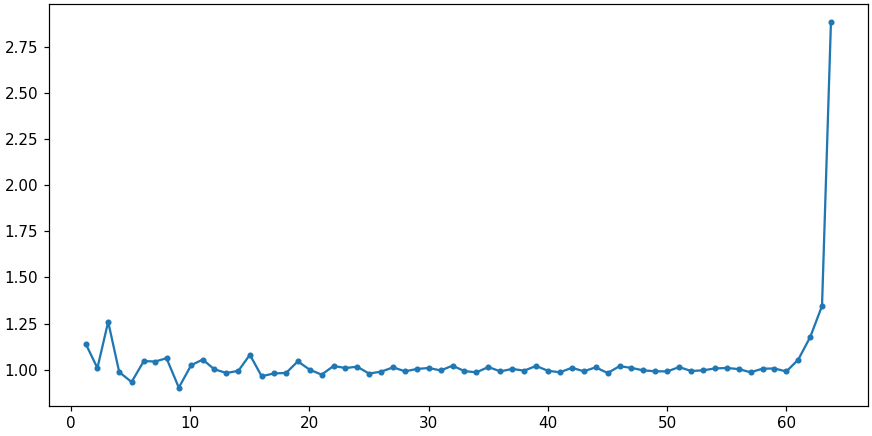

In [15]:
fig, ax = plt.subplots(constrained_layout=True,figsize=(8,4))
plt.plot(k, spheric_coeff, '.-')
plt.show()

# Spatial compensated spectrum from C_2(t=0,k)

<IPython.core.display.Javascript object>


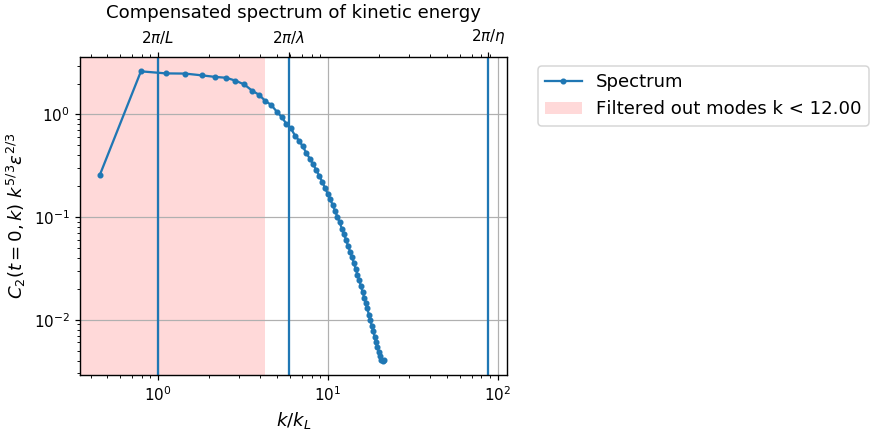

In [16]:
kinetic_energy = 0.5*correlation[0,:]

fig, ax = plt.subplots(constrained_layout=True,figsize=(8,4))
ax.plot(k[:ik_max]/kL, (kinetic_energy*k**(5.0/3.0)*dissipation_rate**(-2.0/3.0)*spheric_coeff)[:ik_max], '.-', label='Spectrum')
#ax.plot(k, 5e-4*k**(-5.0/3.0), label=r'$k^{-5/3}$')
ax.set(xscale='log',yscale='log',xlabel=r'$k/k_L$', ylabel=r'$C_2(t=0,k) \ k^{5/3} \epsilon^{2/3}$', title='Compensated spectrum of kinetic energy')
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid()

vertical_lines=wn_scales/kL
for line in vertical_lines : ax.axvline(x=line)
ax.axvspan(0, cut_off_k/kL, facecolor='red', alpha=0.15, label='Filtered out modes k < %2.2f' % (cut_off_k))
    
ax2 = ax.twiny()
ax2.set(xscale='log', yscale='log', xlim = ax.get_xlim())
ax2.set_xticks(vertical_lines); ax2.set_xticklabels([r'$2\pi/L$', r'$2\pi/\lambda$', r'$2\pi/\eta$'])
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.show()

# pp = PdfPages('Images/transfer_decomp/filtered_spec.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()

In [17]:
#total energy
print(np.sum(kinetic_energy[:ik_max]))
print(np.trapz((kinetic_energy*spheric_coeff)[:ik_max], x=k[:ik_max]))

0.00034710215534572
0.0003339655513851944


<IPython.core.display.Javascript object>


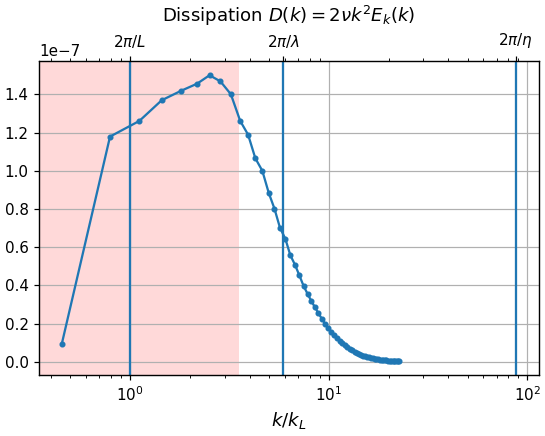

In [18]:
dissipation_spec = 2.0*nu*kinetic_energy*(k**2.0)

fig, ax = plt.subplots(figsize=(5,4), constrained_layout=True)
ax.plot(k/kL, dissipation_spec*spheric_coeff, '.-',label=r'Dissipation $D(k) = 2 \nu k^2 E_k(k)$')
ax.set(xscale='log',yscale='linear',xlabel=r'$k/k_L$', title=r'Dissipation $D(k) = 2 \nu k^2 E_k(k)$'); #ax.set(ylim=[-0.35e-5,10e-6])
ax.grid()

ax.axvspan(0, 10/kL, facecolor='red', alpha=0.15, label=r'Filtered out modes $k < k_c =$%2.2f' % (cut_off_k))

vertical_lines=wn_scales/kL
for line in vertical_lines : ax.axvline(x=line)
ax2 = ax.twiny()
ax2.set(xscale=ax.get_xscale(), yscale=ax.get_yscale(), xlim = ax.get_xlim())
ax2.set_xticks(vertical_lines); ax2.set_xticklabels([r'$2\pi/L$', r'$2\pi/\lambda$', r'$2\pi/\eta$'])
plt.show()

In [19]:
#total dissipation rate (epsilon)
print(np.sum(dissipation_spec))
print(np.trapz(dissipation_spec*spheric_coeff, x=k))
print(dissipation_rate)

2.3484289109526286e-06
2.348022871837814e-06
2.244e-06


# Energy transfer spectrum from T(t=0,k)

<IPython.core.display.Javascript object>


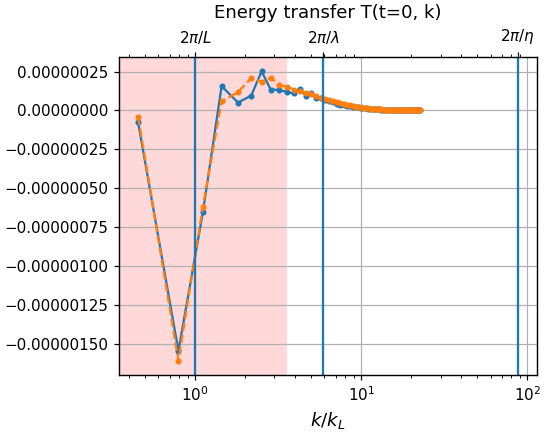

In [20]:
fig, ax = plt.subplots(figsize=(5,4), constrained_layout=True)
ax.plot(k/kL, total_t[t_length//2,::]*spheric_coeff, '.-',label=r'Total T')
ax.plot(k/kL, transfer_spec*spheric_coeff, '.--', label=r'Transfer $T(k)$')
ax.set(xscale='log',yscale='linear',xlabel=r'$k/k_L$', title='Energy transfer T(t=0, k)'); #ax.set(ylim=[-0.35e-5,10e-6])
ax.grid()

ax.axvspan(0, 10/kL, facecolor='red', alpha=0.15, label=r'Filtered out modes $k < k_c =$%2.2f' % (cut_off_k))

vertical_lines=wn_scales/kL
for line in vertical_lines : ax.axvline(x=line)
ax2 = ax.twiny()
ax2.set(xscale=ax.get_xscale(), yscale=ax.get_yscale(), xlim = ax.get_xlim())
ax2.set_xticks(vertical_lines); ax2.set_xticklabels([r'$2\pi/L$', r'$2\pi/\lambda$', r'$2\pi/\eta$'])
plt.show()

<IPython.core.display.Javascript object>


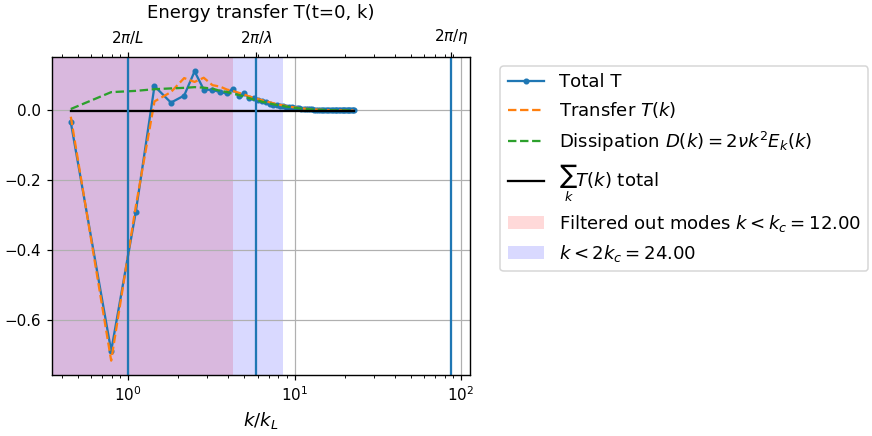

In [21]:
fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)
norm_coef = 1.0/dissipation_rate
ax.plot(k/kL, total_t[t_length//2,::]*spheric_coeff*norm_coef, '.-', label=r'Total T')
ax.plot(k/kL, transfer_spec*spheric_coeff*norm_coef, '--', label=r'Transfer $T(k)$')
ax.plot(k/kL, dissipation_spec*spheric_coeff*norm_coef, '--', label=r'Dissipation $D(k) = 2 \nu k^2 E_k(k)$')
ax.plot(k/kL, np.sum(total_t[t_length//2,::]*norm_coef)*np.ones_like(k), '-', label=r'$\sum_k T(k)$ total', color='black')
#ax.plot(k/kL, np.sum(transf1_spec)*np.ones_like(k), '-', label=r'$\sum_k T(k)$ filtered')
#ax.plot(k, 5e-4*k**(-5.0/3.0), label=r'$k^{-5/3}$')
ax.set(xscale='log',yscale='linear',xlabel=r'$k/k_L$', title='Energy transfer T(t=0, k)'); #ax.set(ylim=[-0.35e-2,0.04])
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid()

ax.axvspan(0, cut_off_k/kL, facecolor='red', alpha=0.15, label=r'Filtered out modes $k < k_c =$%2.2f' % (cut_off_k))
ax.axvspan(0, 2*cut_off_k/kL, facecolor='blue', alpha=0.15, label=r'$k < 2k_c = $%2.2f' % (2*cut_off_k))

vertical_lines=wn_scales/kL
for line in vertical_lines : ax.axvline(x=line)
ax2 = ax.twiny()
ax2.set(xscale=ax.get_xscale(), yscale=ax.get_yscale(), xlim = ax.get_xlim())
ax2.set_xticks(vertical_lines); ax2.set_xticklabels([r'$2\pi/L$', r'$2\pi/\lambda$', r'$2\pi/\eta$'])

lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.show()

# pp = PdfPages('Images/transfer_decomp/transfer_spec.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()

In [22]:
print(np.sum(transfer_spec[:ik_max])/dissipation_rate)
print(np.sum(transfer_spec[:ik_max]*spheric_coeff[:ik_max])/dissipation_rate)
print(np.trapz(transfer_spec[:ik_max],x=k[:ik_max])/dissipation_rate)
print(np.trapz(transfer_spec[:ik_max]*spheric_coeff[:ik_max],x=k[:ik_max])/dissipation_rate)

0.11824579936942979
0.05935030593143613
0.19142093521173548
0.13804938141621914


In [23]:
print(np.sum(total_t[t_length//2,::])/dissipation_rate)
print(np.sum(total_t[t_length//2,::]*spheric_coeff)/dissipation_rate)
print(np.trapz(total_t[t_length//2,::],x=k)/dissipation_rate)
print(np.trapz(total_t[t_length//2,::]*spheric_coeff,x=k)/dissipation_rate)

-0.0004530096653296651
-0.06495616445154977
0.0765550327363069
0.018896577454766507


# Energy flux spectrum from T(t=0,k)

<IPython.core.display.Javascript object>


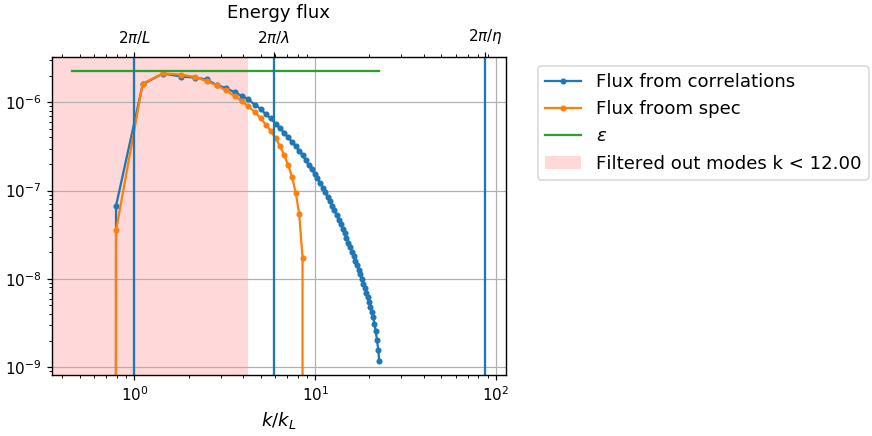

In [24]:
fig, ax = plt.subplots(constrained_layout=True,figsize=(8,4))
flux_total_t = np.zeros(shape=wavenumbers_length, dtype=float)
flux_spec_t = np.zeros(shape=wavenumbers_length, dtype=float)
for ik in list(range(wavenumbers_length)) : 
    flux_total_t[ik] = -np.sum(total_t[t_length//2,0:ik])
    flux_spec_t[ik] = -np.sum(transfer_spec[0:ik])
ax.plot(k/kL, flux_total_t, '.-', label='Flux from correlations')
ax.plot(k/kL, flux_spec_t, '.-', label='Flux froom spec')
ax.plot(k/kL, dissipation_rate*np.ones_like(k), '-', label=r'$\epsilon$')
ax.set(xscale='log',yscale='log',xlabel=r'$k/k_L$', title='Energy flux')
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid()

ax.axvspan(0, cut_off_k/kL, facecolor='red', alpha=0.15, label='Filtered out modes k < %2.2f' % (cut_off_k))

vertical_lines=wn_scales/kL
for line in vertical_lines : ax.axvline(x=line)
ax2 = ax.twiny()
ax2.set(xscale='log', yscale='log', xlim = ax.get_xlim())
ax2.set_xticks(vertical_lines); ax2.set_xticklabels([r'$2\pi/L$', r'$2\pi/\lambda$', r'$2\pi/\eta$'])

lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.show()

# pp = PdfPages('Images/transfer_decomp/flux_spec.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()

# Total energy transfer time dependance

<IPython.core.display.Javascript object>


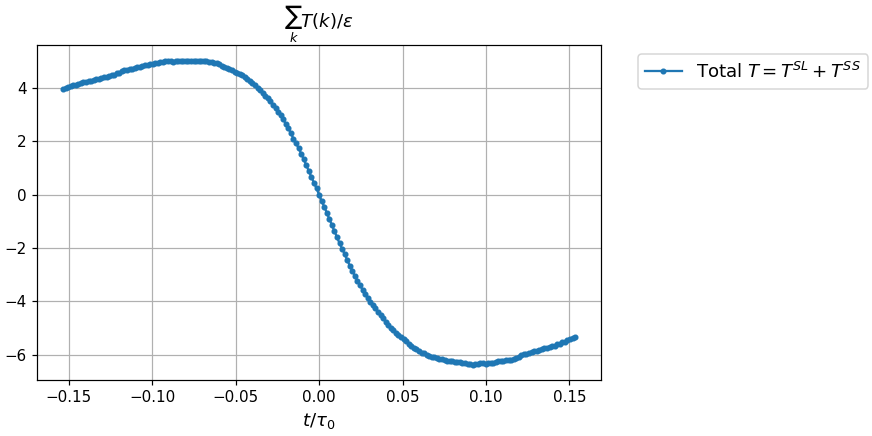

In [26]:
fig, ax = plt.subplots(constrained_layout=True,figsize=(8,4))
normalization_coef = 1.0/dissipation_rate
ax.plot(t/t0, np.sum(total_t[:,::]*normalization_coef, axis=1), '.-', label=r'Total $T = T^{SL} + T^{SS}$')
ax.set(xlabel=r'$t/\tau_0$', title=r'$\sum_{k} T(k)/\epsilon$'); ax.grid()
#ax.set(yscale='log')
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.show()

# pp = PdfPages('Images/transfer_decomp/sum_transfer_vs_time.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()